In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import pickle
import matplotlib.pyplot as plt
import csv
import io
from tqdm import tqdm
import pandas as pd
import string
import pdb
from torch.optim import lr_scheduler
import copy

%matplotlib inline

### Read the .tsv file

In [2]:
def read_tsv(path):
    with open(path) as fd:
        rd = csv.reader(fd, delimiter="\t", quotechar='"')
        sent1, sent2, label = [], [], []
        for idx, row in enumerate(rd):
            if idx == 0:
                label0, label1, label2 = row[0], row[1], row[2]
            else:
                sent1.append(row[0])
                sent2.append(row[1])
                label.append(row[2])
        df = pd.DataFrame()
        df[label0] = sent1
        df[label1] = sent2
        df[label2] = label
    return df

In [3]:
def load_data(dataset):
    try:
        train = read_tsv("./hw2_data/"+dataset+"_train.tsv")
        val = read_tsv("./hw2_data/"+dataset+"_val.tsv")
    except ValueError:
        raise ValueError("Unrecognized dataset")
    return train, val

### Preprocessing Functions

In [4]:
punctuations = string.punctuation
def split(sent):
    tokens = sent.split(' ')
    return [token.lower() for token in tokens if token not in punctuations] 

In [58]:
from collections import Counter
label2digit = {'entailment': 0, 'neutral': 1, 'contradiction': 2}

def build_vocabulary(data):
    all_words = []
    for i in tqdm(range(len(data))):
        all_words += (data[i][0] + data[i][1])
    token_counter = Counter(all_words)
    word, _ = zip(*token_counter.most_common(VOCABULARY_SIZE))
    id2token = ['<pad>','<unk>'] + list(word)
    token2id = dict(zip(id2token, np.arange(len(id2token))))
    return id2token, token2id

def split_token(dataset):
#     assert len(dataset.keys()) == 3
    split_dataset = []
    max_sent_len = 0
    for i in tqdm(range(len(dataset))):
        sent1 = split(dataset.iloc[i]['sentence1'])
        sent2 = split(dataset.iloc[i]['sentence2'])
        label = label2digit[dataset.iloc[i]['label']]
        sample = (sent1, sent2, label)
        split_dataset.append(sample)   
        
        if max(len(sent1), len(sent2)) > max_sent_len:
            max_sent_len = max(len(sent1), len(sent2))
    return split_dataset, max_sent_len

def preprocess(train, val):
    print ('Split tokens...')
    train, max_sent_len = split_token(train)
    val, _ = split_token(val)
    print ("Building vobabulary...")
    id2token, token2id = build_vocabulary(train)
    return train, val, id2token, token2id, max_sent_len

In [6]:
def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in tqdm(fin):
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = list(map(float, tokens[1:]))
    return data

# fasttext_emb = load_vectors("./wiki-news-300d-1M.vec")

In [7]:
def get_embedding_weights(whole_vec, id2token):
    weight = np.zeros((len(id2token), len(whole_vec['sky'])))
    mask = np.zeros((len(id2token)))
    for i, word in enumerate(id2token[1:]):
        if word in whole_vec.keys():
            weight[i] = np.array(whole_vec[word])
        else:
            weight[i] = np.array(whole_vec['UNK'])
            mask[i] = 1
#             print ("Out of vocabulary word: ", word)   
    return weight, mask

### The NLI dataset class

In [8]:
class NLI_dataset(Dataset):
    def __init__(self, data_tuple, token2id):
        self.token2id = token2id
        self.sent1_list, self.sent2_list, self.label_list = zip(*data_tuple)
        assert len(self.sent1_list) == len(self.sent2_list) == len(self.label_list)
        
    def __len__(self):
        return len(self.label_list)
    
    def __getitem__(self, key):
        sent1_idx = [token2id[i] if i in self.token2id.keys() else token2id['<unk>'] for i in self.sent1_list[key][:MAX_SENT_LEN]]
        sent2_idx = [token2id[i] if i in self.token2id.keys() else token2id['<unk>'] for i in self.sent2_list[key][:MAX_SENT_LEN]]
        label = self.label_list[key]
        return [sent1_idx, sent2_idx, label, len(sent1_idx), len(sent2_idx)]
        

def vocab_collate(batch):
    sent1_list, sent2_list, len1_list, len2_list, label_list = [], [], [], [], []
    for datum in batch:
        len1_list.append(datum[3])
        len2_list.append(datum[4])
        label_list.append(datum[2])
        
        padded_sent1 = np.pad(np.array(datum[0]),
                              pad_width=((0, MAX_SENT_LEN-datum[-2])),
                              mode='constant',constant_values=0)
        padded_sent2 = np.pad(np.array(datum[1]),
                              pad_width=((0, MAX_SENT_LEN-datum[-1])),
                              mode='constant',constant_values=0)
        sent1_list.append(padded_sent1)
        sent2_list.append(padded_sent2)
        
#         Ignore sorting the sentences, sort on the fly
    sent1_list, sent2_list, len1_list, len2_list, label_list = np.array(sent1_list),np.array(sent2_list),np.array(len1_list),np.array(len2_list),np.array(label_list)
    return [torch.from_numpy(sent1_list), torch.from_numpy(sent2_list),
            torch.LongTensor(len1_list), torch.LongTensor(len2_list), torch.LongTensor(label_list)]

### Hyperparameter definition

In [9]:
BATCH_SIZE = 1024
VOCABULARY_SIZE = 5000
PAD_IDX = 0
UNK_IDX = 1

In [144]:
train_text, val_text = load_data('snli')

In [145]:
train_set, val_set, id2token, token2id, max_sent_len = preprocess(train_text, val_text)

  0%|          | 417/100000 [00:00<00:23, 4163.04it/s]

Split tokens...


100%|██████████| 100000/100000 [00:00<00:00, 2071066.91it/s]


Building vobabulary...


In [112]:
print ("Number of tokens: ", len(id2token))
print ("Max sentence length: ", max_sent_len)
MAX_SENT_LEN = max_sent_len

Number of tokens:  5002
Max sentence length:  78


In [113]:
train_dataset = NLI_dataset(train_set, token2id)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size = BATCH_SIZE,
                                          collate_fn = vocab_collate,
                                          shuffle = True)

val_dataset = NLI_dataset(val_set, token2id)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                         batch_size=BATCH_SIZE,
                                          collate_fn = vocab_collate,
                                          shuffle = False)

### Construct the pre-trained embedding matrix

In [14]:
fasttext_emb = pickle.load(open('Full_Fasttext_vec.p', 'rb'))
emb_weight, mask = get_embedding_weights(fasttext_emb, id2token)

In [15]:
# pickle.dump(fasttext_emb, open('Full_Fasttext_vec.p', 'wb'))
pickle.dump(emb_weight, open('Emb_weight.p', 'wb'))

### GRU model

In [26]:
class RNN(nn.Module):
    def __init__(self, emb_size, hidden_size, fc_size, num_layers, num_classes, num_vocab, emb_weight, mode='mul'):
        super(RNN, self).__init__()
        self.mode = mode
        self.emb_size = emb_size
        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embed = nn.Embedding(num_vocab, emb_size, padding_idx=PAD_IDX)
        self.embed.weight.data.copy_(torch.from_numpy(emb_weight))
#         self.embed.weight.requires_grad = False
        self.drop_out_rate = 0.3
        self.dropout = nn.Dropout(p=self.drop_out_rate)
        self.gru = nn.GRU(emb_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        if self.mode == 'cat':
            self.linear1 = nn.Linear(hidden_size*4, fc_size)
        elif self.mode == 'mul':
            self.linear1 = nn.Linear(hidden_size*2, fc_size)
        else:
            raise ValueError("Unrecognized mode!")
        self.linear2 = nn.Linear(fc_size, num_classes)
        
    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
#         hidden = torch.randn(self.num_layers, batch_size, self.hidden_size)
        hidden = torch.zeros(self.num_layers*2, batch_size, self.hidden_size)
#                 torch.zeros(self.num_layers, batch_size, self.hidden_size))
        return hidden
    
    def forward(self, sent1, sent2, len1, len2):
#         Get the init hidden input for GRU of first sent
        batch_size, _ = sent1.size()
        self.hidden1 = self.init_hidden(batch_size).to(device)
#         Get the init hidden input for GRU of second sent    
        batch_size, _ = sent2.size()
        self.hidden2 = self.init_hidden(batch_size).to(device)
#         Sort the sent1 batch 
        _, sent1_idx_sort = torch.sort(len1, dim=0, descending=True)
        _, sent1_idx_unsort = torch.sort(sent1_idx_sort, dim=0)
        len1 = len1[sent1_idx_sort]
        sent1 = sent1.index_select(0, sent1_idx_sort)
#         Sort the sent2 batch
        _, sent2_idx_sort = torch.sort(len2, dim=0, descending=True)
        _, sent2_idx_unsort = torch.sort(sent2_idx_sort, dim=0)
        len2 = len2[sent2_idx_sort]
        sent2 = sent2.index_select(0, sent2_idx_sort)
#         Get the emebedding
        
        sent1_embed = self.embed(sent1)
        sent2_embed = self.embed(sent2)
        
        m = (sent1 == 1).type(torch.cuda.FloatTensor).unsqueeze(2).repeat(1, 1, self.emb_size)
        sent1_embed = m * sent1_embed + (1-m) * sent1_embed.clone().detach()
        m = (sent2 == 1).type(torch.cuda.FloatTensor).unsqueeze(2).repeat(1, 1, self.emb_size)
        sent2_embed = m * sent2_embed + (1-m) * sent2_embed.clone().detach()
#         Pack and feed for GRU .cpu().numpy()
        sent1_embed = torch.nn.utils.rnn.pack_padded_sequence(sent1_embed, len1, batch_first=True)
        sent2_embed = torch.nn.utils.rnn.pack_padded_sequence(sent2_embed, len2, batch_first=True)
        
        sent1_out, self.hidden1 = self.gru(sent1_embed, self.hidden1)
        sent2_out, self.hidden2 = self.gru(sent2_embed, self.hidden2)
        
        sent1_out, _ = torch.nn.utils.rnn.pad_packed_sequence(sent1_out, batch_first=True)
        sent2_out, _ = torch.nn.utils.rnn.pad_packed_sequence(sent2_out, batch_first=True)
        
#         Re-sort back to orginal sequence
        self.hidden1 = self.hidden1.index_select(1, sent1_idx_unsort)
        self.hidden2 = self.hidden2.index_select(1, sent2_idx_unsort)

        if self.mode == 'cat':
            cat_emb = torch.cat([self.hidden1, self.hidden2], dim=0).transpose(1,0).contiguous().view(batch_size, -1)
            cat_emb = F.relu(self.linear1(cat_emb))
            cat_emb = self.dropout(cat_emb)
            out = self.linear2(cat_emb.float())
        elif self.mode == "mul":
            mul_emb = torch.mul(self.hidden1, self.hidden2).transpose(1,0).contiguous().view(batch_size, -1)
            mul_emb = F.relu(self.linear1(mul_emb))
            mul_emb = self.dropout(mul_emb)
            out = self.linear2(mul_emb.float())
        else:
            raise ValueError("Unrecognized mode!")
        return F.log_softmax(out, dim=1)

### ConvNet model

In [27]:
import pdb
class CNN(nn.Module):
    def __init__(self, emb_size, hidden_size, fc_size, num_layers, num_classes, vocab_size, emb_weight, k_size=3, pad=1, mode='cat'):

        super(CNN, self).__init__()
        self.emb_size = emb_size
        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX)
        self.embedding.weight.data.copy_(torch.from_numpy(emb_weight))
#         self.embedding.weight.requires_grad = False
        
        self.drop_out_rate = 0.3
        self.dropout = nn.Dropout(p=self.drop_out_rate)
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size=k_size, padding=pad)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=k_size, padding=pad)
        self.linear1 = nn.Linear(hidden_size*2, fc_size)
        self.linear2 = nn.Linear(fc_size, num_classes)
        
        self.maxpool = nn.MaxPool1d(kernel_size=MAX_SENT_LEN)

    def forward(self, sent1, sent2, len1, len2):
        batch_size, length = sent1.size()
#         pdb.set_trace()
        embed1 = self.embedding(sent1)
    
        m = (sent1 == 1).type(torch.cuda.FloatTensor).unsqueeze(2).repeat(1, 1, self.emb_size)
        embed1 = m * embed1 + (1-m) * embed1.clone().detach()
        
        embed2 = self.embedding(sent2)
        m = (sent2 == 1).type(torch.cuda.FloatTensor).unsqueeze(2).repeat(1, 1, self.emb_size)
        embed2 = m * embed2 + (1-m) * embed2.clone().detach()
        
        hidden1 = self.conv1(embed1.transpose(1,2)).transpose(1,2)
        hidden2 = self.conv1(embed2.transpose(1,2)).transpose(1,2)
#         pdb.set_trace()
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size, length, hidden1.size(-1))
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size, length, hidden2.size(-1))

        hidden1 = self.conv2(hidden1.transpose(1,2)).transpose(1,2)
        hidden2 = self.conv2(hidden2.transpose(1,2)).transpose(1,2)
        
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size, length, hidden1.size(-1))
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size, length, hidden2.size(-1))
#         pdb.set_trace()
        hidden1 = self.maxpool(hidden1.transpose(2,1))
        hidden2 = self.maxpool(hidden2.transpose(2,1))
        

        cat_emb = torch.cat([hidden1, hidden2], dim=1).view(batch_size, -1)
        cat_emb = F.relu(self.linear1(cat_emb))
        out = self.linear2(cat_emb.float())
        
        return F.log_softmax(out, dim=1)

### Train and test function 

In [28]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data1, data2, len1, len2, labels in loader:
#         data1_batch, data2_batch, len1_batch, len2_batch, label_batch = data1, data2, len1, len2, labels
        data1, data2, len1, len2, labels = data1.to(device), data2.to(device), len1.to(device), len2.to(device), labels.to(device)
        outputs = model(data1, data2, len1, len2)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

def train(model, learning_rate, num_epochs, weight_decay_rate, patience=3):
    best_acc = 0
    best_model_wts = copy.deepcopy(model.state_dict())
    epochs_after_best = 0
    train_accs, val_accs = [], []
    # Criterion and Optimizer
    criterion = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay_rate)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.5)
    # Train the model
    total_step = len(train_loader)

    for epoch in range(num_epochs):
        scheduler.step()
        for i, (data1, data2, len1, len2, labels) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            data1, data2, len1, len2, labels = data1.to(device), data2.to(device), len1.to(device), len2.to(device), labels.to(device)
            # Forward pass
            outputs = model(data1, data2, len1, len2)
            loss = criterion(outputs, labels)
            # Backward and optimize
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
#             if i > 0 and (i+1) % 500 == 0:
                # validate
        train_acc = test_model(train_loader, model)
        val_acc = test_model(val_loader, model)
        print('Epoch: [{}/{}], Train Acc: {}, Validation Acc: {}'.format(
                           epoch+1, num_epochs, train_acc, val_acc))
        train_accs.append(train_acc)
        val_accs.append(val_acc)
                
        if val_acc >= best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_after_best = 0
        else:
            epochs_after_best += 1

        if epochs_after_best > patience:
            break
    print ("Trainging terminated, best accuracy: ", best_acc)
    model.load_state_dict(best_model_wts)
    logs = {'train_acc': train_accs, 'val_acc': val_accs}     
    return model, logs, best_acc
    

### Utils function

In [29]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [30]:
def plot_acc(ablation_logs, title):
    plt.figure(figsize=(20,7))
    color = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
    variables = ablation_logs.keys()
    plt.subplot(1,2,1)
    for idx, key in enumerate(variables):
        train_log = ablation_logs[key][1]['train_acc']
        val_log = ablation_logs[key][1]['val_acc']
        num_epochs = np.arange(len(train_log))
        plt.plot(num_epochs, train_log, color=color[idx], label=ablation_logs[key][0])
    plt.title("Train Accuracy vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.subplot(1,2,2)
    for idx, key in enumerate(variables):
        train_log = ablation_logs[key][1]['train_acc']
        val_log = ablation_logs[key][1]['val_acc']
        num_epochs = np.arange(len(train_log))
        plt.plot(num_epochs, val_log, color=color[idx], label=ablation_logs[key][0])
    plt.title("Validataion Accuracy vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
#     plt.show()
    plt.savefig("./"+title)

### Ablation study for RNN

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

emb_weight = pickle.load(open('Emb_weight.p', 'rb'))

learning_rate = 6e-4
num_epochs = 30
best_acc = 0

In [32]:
best_model = None
rnn_hidden_size_ablation = {}
for hidden_size in [200, 300, 400, 500, 600]: 
    model = RNN(emb_size=300, hidden_size=hidden_size, fc_size=32, num_layers=1,
            num_classes=3, num_vocab=len(token2id), emb_weight=emb_weight, mode='cat')
    n_param = count_parameters(model)
    model_param = "RNN=>Hidden_size: {}, Mode: {}, #_trained_parameters:{}".format(hidden_size, 'cat', n_param)
    model = model.to(device)
    print ("Training model: ", model_param)
    model, logs, acc = train(model, learning_rate, num_epochs, weight_decay_rate=0)
    rnn_hidden_size_ablation[hidden_size] = (model_param, logs)
    
    torch.save(model, "./models/"+model_param+'_'+str(acc)+'.pth')
#     if val_acc >= best_acc:
#         best_acc = val_acc
#         best_model_wts = copy.deepcopy(model.state_dict())
# #         best_model_name = model_param+'__'+str(best_acc)+'.pth'

# torch.save(best_model, best_model_name)

Training model:  RNN=>Hidden_size: 200, Mode: cat, #_trained_parameters:2128731
Epoch: [1/30], Train Acc: 64.159, Validation Acc: 61.8
Epoch: [2/30], Train Acc: 67.431, Validation Acc: 63.6
Epoch: [3/30], Train Acc: 68.741, Validation Acc: 64.1
Epoch: [4/30], Train Acc: 69.451, Validation Acc: 64.4
Epoch: [5/30], Train Acc: 70.536, Validation Acc: 63.9
Epoch: [6/30], Train Acc: 71.319, Validation Acc: 64.1
Epoch: [7/30], Train Acc: 72.154, Validation Acc: 64.3
Epoch: [8/30], Train Acc: 72.931, Validation Acc: 63.9
Trainging terminated, best accuracy:  64.4
Training model:  RNN=>Hidden_size: 300, Mode: cat, #_trained_parameters:2622731


/home/videolab/anaconda3/lib/python3.7/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [1/30], Train Acc: 62.199, Validation Acc: 60.8
Epoch: [2/30], Train Acc: 67.166, Validation Acc: 64.1
Epoch: [3/30], Train Acc: 68.776, Validation Acc: 64.2
Epoch: [4/30], Train Acc: 69.944, Validation Acc: 65.0
Epoch: [5/30], Train Acc: 70.605, Validation Acc: 65.7
Epoch: [6/30], Train Acc: 71.555, Validation Acc: 64.5
Epoch: [7/30], Train Acc: 72.645, Validation Acc: 64.1
Epoch: [8/30], Train Acc: 73.58, Validation Acc: 63.5
Epoch: [9/30], Train Acc: 74.649, Validation Acc: 63.5
Trainging terminated, best accuracy:  65.7
Training model:  RNN=>Hidden_size: 400, Mode: cat, #_trained_parameters:3236731
Epoch: [1/30], Train Acc: 64.035, Validation Acc: 60.9
Epoch: [2/30], Train Acc: 67.723, Validation Acc: 63.3
Epoch: [3/30], Train Acc: 68.781, Validation Acc: 64.0
Epoch: [4/30], Train Acc: 69.795, Validation Acc: 65.0
Epoch: [5/30], Train Acc: 70.68, Validation Acc: 66.3
Epoch: [6/30], Train Acc: 71.598, Validation Acc: 66.1
Epoch: [7/30], Train Acc: 72.811, Validation Acc: 65.8

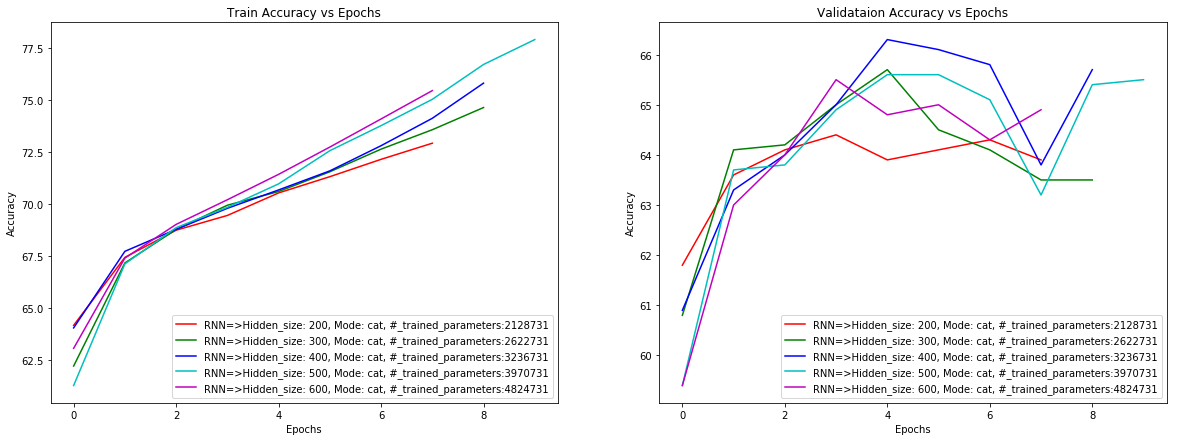

In [33]:
plot_acc(rnn_hidden_size_ablation, "Ablation_RNN_Hidden_size")

In [34]:
best_model = None
mode_ablation = {}
hidden_size=400
for mode in ['cat', 'mul']: 
    model = RNN(emb_size=300, hidden_size=hidden_size, fc_size=32, num_layers=1,
            num_classes=3, num_vocab=len(token2id), emb_weight=emb_weight, mode=mode)
    n_param = count_parameters(model)
    model_param = "RNN=>Hidden_size: {}, Mode: {}, #_trained_parameters: {}".format(hidden_size, mode, n_param)
    model = model.to(device)
    print ("Training model: ", model_param)
#     num_epochs = 1
    model, logs, acc = train(model, learning_rate, num_epochs, weight_decay_rate=0)
    mode_ablation[mode] = (model_param, logs)
    
    torch.save(model, "./models/"+model_param+'_'+str(acc)+'.pth')
#     if best_acc < acc:
#         best_acc = acc
#         best_model = copy.deepcopy(model)
#         best_model_name = model_param+'_'+str(best_acc)+'.pth'

# torch.save(best_model, best_model_name)

Training model:  RNN=>Hidden_size: 400, Mode: cat, #_trained_parameters: 3236731
Epoch: [1/30], Train Acc: 64.121, Validation Acc: 60.9
Epoch: [2/30], Train Acc: 67.611, Validation Acc: 64.1
Epoch: [3/30], Train Acc: 68.696, Validation Acc: 64.6
Epoch: [4/30], Train Acc: 69.845, Validation Acc: 65.0
Epoch: [5/30], Train Acc: 71.159, Validation Acc: 65.3
Epoch: [6/30], Train Acc: 72.172, Validation Acc: 65.9
Epoch: [7/30], Train Acc: 73.549, Validation Acc: 64.4
Epoch: [8/30], Train Acc: 74.62, Validation Acc: 64.7
Epoch: [9/30], Train Acc: 76.255, Validation Acc: 63.4
Epoch: [10/30], Train Acc: 76.983, Validation Acc: 63.2
Trainging terminated, best accuracy:  65.9
Training model:  RNN=>Hidden_size: 400, Mode: mul, #_trained_parameters: 3211131


/home/videolab/anaconda3/lib/python3.7/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [1/30], Train Acc: 56.053, Validation Acc: 55.2
Epoch: [2/30], Train Acc: 63.763, Validation Acc: 62.9
Epoch: [3/30], Train Acc: 66.896, Validation Acc: 63.6
Epoch: [4/30], Train Acc: 68.871, Validation Acc: 64.6
Epoch: [5/30], Train Acc: 70.728, Validation Acc: 65.4
Epoch: [6/30], Train Acc: 72.217, Validation Acc: 65.6
Epoch: [7/30], Train Acc: 73.585, Validation Acc: 65.9
Epoch: [8/30], Train Acc: 75.12, Validation Acc: 65.8
Epoch: [9/30], Train Acc: 76.501, Validation Acc: 65.8
Epoch: [10/30], Train Acc: 77.542, Validation Acc: 66.6
Epoch: [11/30], Train Acc: 78.365, Validation Acc: 65.1
Epoch: [12/30], Train Acc: 79.491, Validation Acc: 65.1
Epoch: [13/30], Train Acc: 80.539, Validation Acc: 65.2
Epoch: [14/30], Train Acc: 81.378, Validation Acc: 65.4
Trainging terminated, best accuracy:  66.6


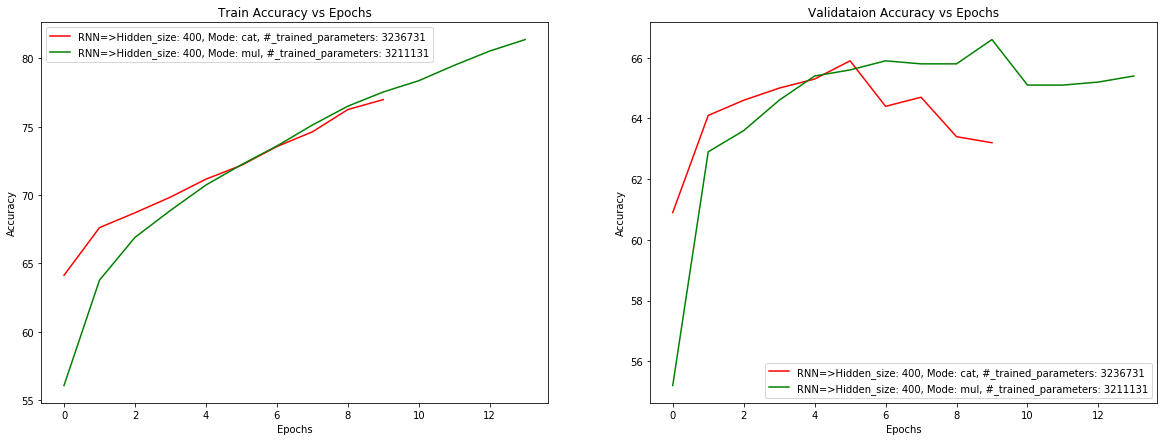

In [35]:
plot_acc(mode_ablation, "Ablation_RNN_interaction_mode")

### Ablation Study for the CNN

In [39]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

emb_weight = pickle.load(open('Emb_weight.p', 'rb'))

learning_rate = 5e-4
num_epochs = 30
best_acc = 0

In [40]:
hidden_size_ablation = {}
for hidden_size in [100, 200, 300, 400, 500]: 
    model = CNN(emb_size=300, hidden_size=hidden_size, fc_size=32, num_layers=1,
                num_classes=3, vocab_size=len(token2id), emb_weight=emb_weight, k_size=3, pad=1)
    n_param = count_parameters(model)
    model_param = "CNN=>Hidden_size: {}, Kernel_size: {}, #_trained_parameters:{}".format(hidden_size, 3, n_param)
    model = model.to(device)
    print ("Training model: ", model_param)
#     num_epochs = 1
    model, logs, acc = train(model, learning_rate, num_epochs, weight_decay_rate=0)
    hidden_size_ablation[hidden_size] = (model_param, logs)
    
    if best_acc < acc:
        best_acc = acc
        best_model = copy.deepcopy(model)
        best_model_name = model_param+'__'+str(best_acc)+'.pth'

torch.save(best_model, "./models/"+best_model_name)

Training model:  CNN=>Hidden_size: 100, Kernel_size: 3, #_trained_parameters:1627331
Epoch: [1/30], Train Acc: 53.736, Validation Acc: 52.2
Epoch: [2/30], Train Acc: 65.168, Validation Acc: 62.6
Epoch: [3/30], Train Acc: 67.31, Validation Acc: 63.4
Epoch: [4/30], Train Acc: 68.746, Validation Acc: 63.7
Epoch: [5/30], Train Acc: 69.557, Validation Acc: 63.1
Epoch: [6/30], Train Acc: 70.329, Validation Acc: 62.8
Epoch: [7/30], Train Acc: 70.99, Validation Acc: 63.6
Epoch: [8/30], Train Acc: 71.64, Validation Acc: 64.3
Epoch: [9/30], Train Acc: 72.331, Validation Acc: 65.2
Epoch: [10/30], Train Acc: 72.743, Validation Acc: 64.2
Epoch: [11/30], Train Acc: 73.195, Validation Acc: 64.2
Epoch: [12/30], Train Acc: 73.674, Validation Acc: 64.5
Epoch: [13/30], Train Acc: 74.206, Validation Acc: 63.8
Trainging terminated, best accuracy:  65.2
Training model:  CNN=>Hidden_size: 200, Kernel_size: 3, #_trained_parameters:1813931
Epoch: [1/30], Train Acc: 58.512, Validation Acc: 58.2
Epoch: [2/30], T

/home/videolab/anaconda3/lib/python3.7/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


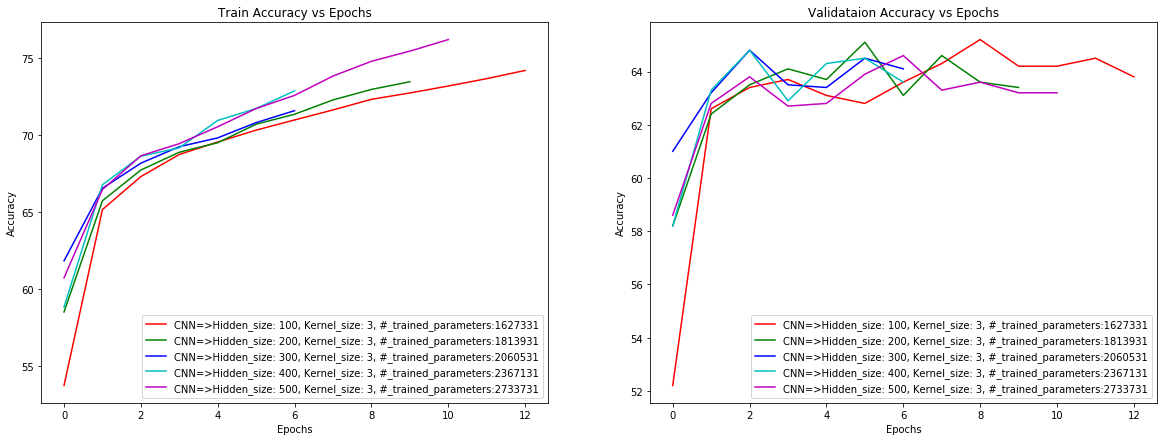

In [41]:
plot_acc(hidden_size_ablation, "Ablation_CNN_Hidden_size")

In [42]:
kernel_size_ablation = {}
for kernel_size in [3, 5, 7]:
#     model_param = "Hidden_size: {}, Kernel_size: {}, Weight_decay_rate: {}, Mode: {}".format(300, kernel_size, 0, 'Concatenation') 
    model = CNN(emb_size=300, hidden_size=100, fc_size=32, num_layers=1,
                num_classes=3, vocab_size=len(token2id), emb_weight=emb_weight, k_size=kernel_size, pad=int(kernel_size/2))
    n_param = count_parameters(model)
    model_param = "CNN=>Hidden_size: {}, Kernel_size: {}, #_trained_parameters: {}".format(100, kernel_size, n_param)
    model = model.to(device)
    print ("Training model: ", model_param)
    model, logs, acc = train(model, learning_rate, num_epochs, weight_decay_rate=0)
    kernel_size_ablation[kernel_size] = (model_param, logs)
    
    if best_acc < acc:
        best_acc = acc
        best_model = copy.deepcopy(model)
        best_model_name = model_param+'__'+str(best_acc)+'.pth'

torch.save(best_model, "./models/"+best_model_name)

Training model:  CNN=>Hidden_size: 100, Kernel_size: 3, #_trained_parameters: 1627331
Epoch: [1/30], Train Acc: 60.678, Validation Acc: 59.8
Epoch: [2/30], Train Acc: 65.977, Validation Acc: 63.4
Epoch: [3/30], Train Acc: 67.474, Validation Acc: 63.1
Epoch: [4/30], Train Acc: 68.519, Validation Acc: 63.4
Epoch: [5/30], Train Acc: 69.242, Validation Acc: 63.5
Epoch: [6/30], Train Acc: 69.897, Validation Acc: 62.9
Epoch: [7/30], Train Acc: 70.597, Validation Acc: 63.7
Epoch: [8/30], Train Acc: 70.71, Validation Acc: 61.7
Epoch: [9/30], Train Acc: 71.463, Validation Acc: 63.6
Epoch: [10/30], Train Acc: 71.861, Validation Acc: 62.5
Epoch: [11/30], Train Acc: 72.274, Validation Acc: 63.7
Epoch: [12/30], Train Acc: 72.568, Validation Acc: 62.7
Epoch: [13/30], Train Acc: 72.908, Validation Acc: 62.9
Epoch: [14/30], Train Acc: 73.13, Validation Acc: 62.7
Epoch: [15/30], Train Acc: 73.629, Validation Acc: 62.7
Trainging terminated, best accuracy:  63.7
Training model:  CNN=>Hidden_size: 100, Ke

/home/videolab/anaconda3/lib/python3.7/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


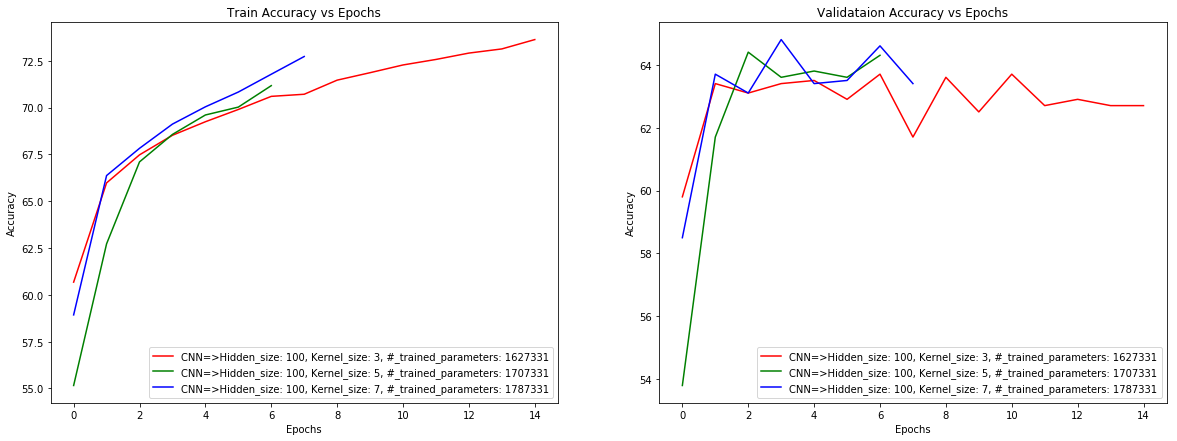

In [43]:
plot_acc(kernel_size_ablation, "Ablation_CNN_Kernel_size")

In [45]:
num_epochs = 30
learning_rate = 3e-4
weight_decay_ablation = {}
for decay_rate in [3e-4, 5e-4, 7e-4, 10e-4]:
    model_param = "Hidden_size: {}, Kernel_size: {}, Weight_decay_rate: {}, Mode: {}".format(300, 3, decay_rate, 'Concatenation') 
    model = CNN(emb_size=300, hidden_size=300, fc_size=32, num_layers=1,
                num_classes=3, vocab_size=len(token2id), emb_weight=emb_weight, k_size=3, pad=1)
    model = model.to(device)
    print ("Training model: ", model_param)
    model, logs, acc = train(model, learning_rate, num_epochs, weight_decay_rate=decay_rate)
    weight_decay_ablation[decay_rate] = (model_param, logs)
    
    if best_acc < acc:
        best_acc = acc
        best_model = copy.deepcopy(model)
        best_model_name = model_param+'__'+str(best_acc)+'.pth'

torch.save(best_model, best_model_name)

Training model:  Hidden_size: 300, Kernel_size: 3, Weight_decay_rate: 0.0003, Mode: Concatenation
Epoch: [1/30], Train Acc: 50.732, Validation Acc: 49.1
Epoch: [2/30], Train Acc: 55.584, Validation Acc: 55.1
Epoch: [3/30], Train Acc: 59.972, Validation Acc: 59.1
Epoch: [4/30], Train Acc: 64.613, Validation Acc: 63.2
Epoch: [5/30], Train Acc: 66.703, Validation Acc: 63.6
Epoch: [6/30], Train Acc: 67.935, Validation Acc: 63.3
Epoch: [7/30], Train Acc: 68.457, Validation Acc: 63.9
Epoch: [8/30], Train Acc: 68.872, Validation Acc: 63.0
Epoch: [9/30], Train Acc: 69.51, Validation Acc: 64.1
Epoch: [10/30], Train Acc: 69.598, Validation Acc: 64.0
Epoch: [11/30], Train Acc: 69.935, Validation Acc: 64.1
Epoch: [12/30], Train Acc: 70.117, Validation Acc: 63.1
Epoch: [13/30], Train Acc: 70.297, Validation Acc: 63.2
Epoch: [14/30], Train Acc: 70.493, Validation Acc: 63.3
Epoch: [15/30], Train Acc: 70.683, Validation Acc: 62.6
Trainging terminated, best accuracy:  64.1
Training model:  Hidden_size:

/home/videolab/anaconda3/lib/python3.7/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


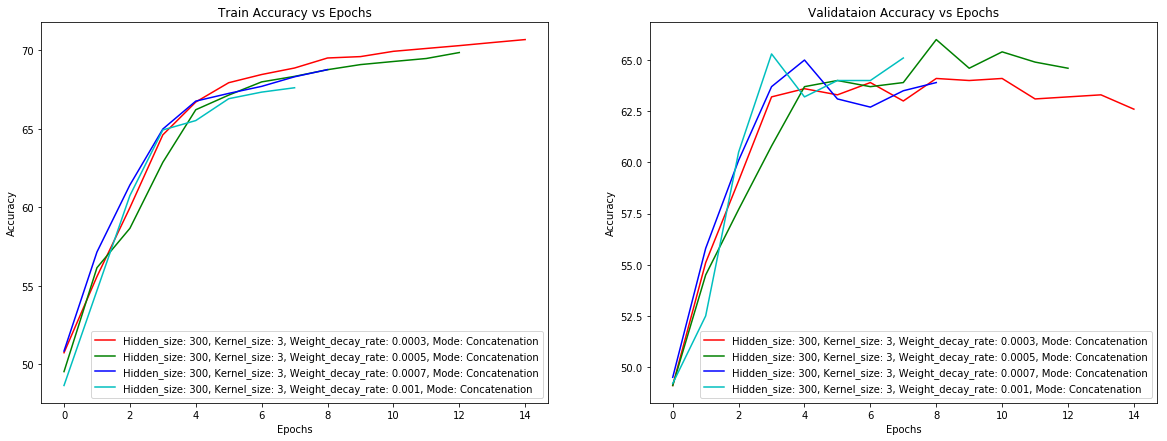

In [46]:
plot_acc(weight_decay_ablation, "Ablation_CNN_weight_decay_rate")

### Collect correct and incorrect case

In [140]:
model = torch.load("./models/RNN=>Hidden_size: 400, Mode: mul, #_trained_parameters: 3211131_66.6.pth")
correct_list = []
incorrect_list = []
model.eval()
correct = 0
total = 0
for data1, data2, len1, len2, labels in val_loader:
    data1, data2, len1, len2, labels = data1.to(device), data2.to(device), len1.to(device), len2.to(device), labels.to(device)
    outputs = model(data1, data2, len1, len2)
    predicted = outputs.max(1, keepdim=True)[1]

    total += labels.size(0)
    correct_list += [i for i in range(predicted.size()[0]) if predicted[i].item() == labels.view_as(predicted)[i].item()]
    incorrect_list += [i for i in range(predicted.size()[0]) if predicted[i].item() != labels.view_as(predicted)[i].item()]
    correct += predicted.eq(labels.view_as(predicted)).sum().item()


In [149]:
# Correct case:
print ("Correct case: ")
val_text.take(correct_list[:3])

Correct case: 


,sentence1,sentence2,label
0,"Three women on a stage , one wearing red shoes...",There are two women standing on the stage,contradiction
1,"Four people sit on a subway two read books , o...","Multiple people are on a subway together , wit...",entailment
2,bicycles stationed while a group of people soc...,People get together near a stand of bicycles .,entailment


In [148]:
# Incorrect case:
print ("Incorrect case: ")
val_text.take(incorrect_list[:3])

Incorrect case: 


,sentence1,sentence2,label
5,Two people are in a green forest .,The forest is not dead .,entailment
9,Three people and a white dog are sitting in th...,Three dogs and a person are sitting in the snow .,contradiction
11,A large group of people stand outside on a roa...,One group of people are watching what another ...,entailment


### MNLI dataset

In [60]:
def read_tsv_m(path):
    with open(path) as fd:
        rd = csv.reader(fd, delimiter="\t", quotechar='"')
        sent1, sent2, label, genre = [], [], [], []
        for idx, row in enumerate(rd):
            if idx == 0:
                label0, label1, label2, label3 = row[0], row[1], row[2], row[3]
            else:
                sent1.append(row[0])
                sent2.append(row[1])
                label.append(row[2])
                genre.append(row[3])
        df = pd.DataFrame()
        df[label0] = sent1
        df[label1] = sent2
        df[label2] = label
        df[label3] = genre
    return df

In [61]:
def load_data_m(dataset):
    try:
        train = read_tsv_m("./hw2_data/"+dataset+"_train.tsv")
        val = read_tsv_m("./hw2_data/"+dataset+"_val.tsv")
    except ValueError:
        raise ValueError("Unrecognized dataset")
    return train, val

In [62]:
train_set, val_set = load_data_m('mnli')
genre_type = set(train_set['genre'])
print (genre_type)

{'telephone', 'slate', 'government', 'travel', 'fiction'}


In [63]:
dataset = {}
for genre in genre_type:
    index_list = [i for i in range(len(train_set)) if train_set['genre'][i] == genre]
    train_genre_df = train_set.take(index_list)
    
    index_list = [i for i in range(len(val_set)) if val_set['genre'][i] == genre]
    val_genre_df = val_set.take(index_list)
    train_genre_df, val_genre_df, _, _, _ = preprocess(train_genre_df, val_genre_df)
    genre_dataset = {"train": train_genre_df, "val": val_genre_df}
    dataset[genre] = genre_dataset

 12%|█▏        | 521/4270 [00:00<00:00, 5208.08it/s]

Split tokens...


100%|██████████| 4270/4270 [00:00<00:00, 1258232.27it/s]


Building vobabulary...


 13%|█▎        | 529/4026 [00:00<00:00, 5281.18it/s]

Split tokens...


100%|██████████| 4026/4026 [00:00<00:00, 1441792.00it/s]


Building vobabulary...


100%|██████████| 3883/3883 [00:00<00:00, 1161412.14it/s]


Split tokens...
Building vobabulary...


 13%|█▎        | 522/3985 [00:00<00:00, 5215.44it/s]

Split tokens...


100%|██████████| 3985/3985 [00:00<00:00, 1294177.42it/s]


Building vobabulary...


 28%|██▊       | 1063/3836 [00:00<00:00, 5308.66it/s]

Split tokens...


100%|██████████| 3836/3836 [00:00<00:00, 1444027.12it/s]


Building vobabulary...


### Evaluate the pre-trained model from SNLI on MNLI

In [66]:
import sys
import warnings

# Sometimes warning raise when load the rnn model since the memory space of rnn is not continous thus is not efficient
# Ignore to print the form in one piece
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [100]:
cnn_model = torch.load('./Hidden_size: 300, Kernel_size: 3, Weight_decay_rate: 0.0005, Mode: Concatenation__66.0.pth')
rnn_model = torch.load("./models/RNN=>Hidden_size: 400, Mode: mul, #_trained_parameters: 3211131_66.6.pth")

print('{:8s}\t\t{:8s}\t\t{:5s}'.format("Model", 'Genre', "Accuracy"))

for genre in genre_type:
    train_set = dataset[genre]['train']
    val_set = dataset[genre]['val']
#     train_set, val_set, _, _, _ = preprocess(train_set, val_set)
    
#     train_dataset = NLI_dataset(train_set, token2id)
#     train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
#                                            batch_size = BATCH_SIZE,
#                                           collate_fn = vocab_collate,
#                                           shuffle = True)

    val_dataset = NLI_dataset(val_set, token2id)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                         batch_size=BATCH_SIZE,
                                          collate_fn = vocab_collate,
                                          shuffle = False)
    acc = test_model(val_loader, cnn_model)
    
    print ('{:8s}\t\t{:8s}\t\t{:2f}'.format('ConvNet', genre, acc))
    
    acc = test_model(val_loader, rnn_model)
    print ('{:8s}\t\t{:8s}\t\t{:2f}'.format('RNN', genre, acc))

Model   		Genre   		Accuracy
ConvNet 		telephone		42.587065
RNN     		telephone		45.373134
ConvNet 		slate   		40.219561
RNN     		slate   		39.520958
ConvNet 		government		39.665354
RNN     		government		37.303150
ConvNet 		travel  		41.038697
RNN     		travel  		42.158859
ConvNet 		fiction 		42.713568
RNN     		fiction 		41.809045


### Fine-tuning and evaluation

In [104]:
def cross_check_acc(model, name):
    print('{:8s}\t\t{:8s}\t\t{:5s}'.format("Model", 'Genre', "Accuracy"))
    for genre in genre_type:
        train_set = dataset[genre]['train']
        val_set = dataset[genre]['val']

        val_dataset = NLI_dataset(val_set, token2id)
        val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                         batch_size=BATCH_SIZE,
                                          collate_fn = vocab_collate,
                                          shuffle = False)
        acc = test_model(val_loader, model)
        print ('{:8s}\t\t{:8s}\t\t{:5f}'.format(name, genre, acc))
    

In [108]:
num_epochs = 25
learning_rate_rateing_rate = 4e-5

for genre in genre_type:
    train_set = dataset[genre]['train']
    val_set = dataset[genre]['val']
    
#     train_set, val_set, _, _, _ = preprocess(train_set, val_set)
    train_dataset = NLI_dataset(train_set, token2id)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size = BATCH_SIZE,
                                          collate_fn = vocab_collate,
                                          shuffle = True)
    val_dataset = NLI_dataset(val_set, token2id)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                         batch_size=BATCH_SIZE,
                                          collate_fn = vocab_collate,
                                          shuffle = False)
    
    cnn_model = torch.load('./Hidden_size: 300, Kernel_size: 3, Weight_decay_rate: 0.0005, Mode: Concatenation__66.0.pth')
    rnn_model = torch.load("./models/RNN=>Hidden_size: 400, Mode: mul, #_trained_parameters: 3211131_66.6.pth")

    print ("--"*50)
    print ("Fine tuning", "ConvNet Model ", "on: ", genre)
    cnn_model, logs, acc = train(cnn_model, learning_rate, num_epochs, weight_decay_rate=0)
    print ("--"*50)
    print ("Evaluation:", "ConvNet Model ", "on: ", genre)
    cross_check_acc(cnn_model, "Conv_"+genre)
    print ("--"*50)
    print ("Fine tuning", "RNN Model ", "on: ", genre)
    rnn_model, logs, acc = train(rnn_model, learning_rate, num_epochs, weight_decay_rate=0)
    print ("--"*50)
    print ("Evaluation:", "RNN Model ", "on: ", genre)
    cross_check_acc(rnn_model, "RNN_"+genre)

----------------------------------------------------------------------------------------------------
Fine tuning ConvNet Model  on:  telephone
Epoch: [1/25], Train Acc: 44.566744730679154, Validation Acc: 47.86069651741293
Epoch: [2/25], Train Acc: 45.62060889929742, Validation Acc: 46.666666666666664
Epoch: [3/25], Train Acc: 49.133489461358316, Validation Acc: 49.850746268656714
Epoch: [4/25], Train Acc: 51.38173302107728, Validation Acc: 48.656716417910445
Epoch: [5/25], Train Acc: 53.09133489461358, Validation Acc: 48.55721393034826
Epoch: [6/25], Train Acc: 54.68384074941452, Validation Acc: 49.0547263681592
Epoch: [7/25], Train Acc: 56.53395784543326, Validation Acc: 48.656716417910445
Trainging terminated, best accuracy:  49.850746268656714
----------------------------------------------------------------------------------------------------
Evaluation: ConvNet Model  on:  telephone
Model   		Genre   		Accuracy
Conv_telephone		telephone		49.850746
Conv_telephone		slate   		41.9161

Epoch: [8/25], Train Acc: 54.05614215812516, Validation Acc: 49.90157480314961
Epoch: [9/25], Train Acc: 54.80298738089106, Validation Acc: 50.0
Epoch: [10/25], Train Acc: 55.3180530517641, Validation Acc: 50.09842519685039
Epoch: [11/25], Train Acc: 55.91037857326809, Validation Acc: 50.78740157480315
Epoch: [12/25], Train Acc: 56.73448364666495, Validation Acc: 51.77165354330709
Epoch: [13/25], Train Acc: 57.378315735256244, Validation Acc: 50.688976377952756
Epoch: [14/25], Train Acc: 57.610095287149115, Validation Acc: 50.98425196850393
Epoch: [15/25], Train Acc: 57.81612155549833, Validation Acc: 51.08267716535433
Epoch: [16/25], Train Acc: 58.408447077002315, Validation Acc: 50.98425196850393
Trainging terminated, best accuracy:  51.77165354330709
----------------------------------------------------------------------------------------------------
Evaluation: RNN Model  on:  government
Model   		Genre   		Accuracy
RNN_government		telephone		49.054726
RNN_government		slate   		42.7

RNN_fiction		slate   		43.213573
RNN_fiction		government		49.901575
RNN_fiction		travel  		47.352342
RNN_fiction		fiction 		48.442211
